# BTC vs U.S. M2 Liquidity - 120-Day Rolling Correlation

This notebook uses two local datasets:
- `../data/M2SL.csv`: M2 money supply from the Fed (billions of USD, monthly).

- `../data/btc_daily_ccxt.csv`: Daily BTC OHLCV from the CCXT fetcher.

We align M2 to a daily cadence (forward-fill between release dates), then measure the 120-day rolling correlation between BTC closing price and M2. Additional quick stats help contextualize the relationship.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid')
DATA_DIR = Path('../data')
m2_path = DATA_DIR / 'M2SL.csv'
btc_path = DATA_DIR / 'btc_daily_ccxt.csv'
spx_path = DATA_DIR / 'spx_daily_yfinance.csv'

m2 = pd.read_csv(m2_path, parse_dates=['observation_date'])
btc = pd.read_csv(btc_path, parse_dates=['date_utc'])
spx = pd.read_csv(spx_path, parse_dates=['date'])

m2['M2SL'] = pd.to_numeric(m2['M2SL'], errors='coerce')
for col in ['open','high','low','close','volume']:
    btc[col] = pd.to_numeric(btc[col], errors='coerce')
spx['Close'] = pd.to_numeric(spx['Close'], errors='coerce')
spx = spx.dropna(subset=['date','Close'])
spx = spx.rename(columns={'Close':'spx_close'})

display(m2.head())
display(btc.head())
display(spx.head())


,observation_date,M2SL
0,1959-01-01,286.6
1,1959-02-01,287.7
2,1959-03-01,289.2
3,1959-04-01,290.1
4,1959-05-01,292.2


,timestamp_ms,date_utc,open,high,low,close,volume
0,1677369600000,2023-02-26,23157.07,23689.99,23059.18,23554.85,202323.73623
1,1677456000000,2023-02-27,23554.85,23897.99,23106.77,23492.09,283706.08590
2,1677542400000,2023-02-28,23492.09,23600.00,23020.97,23141.57,264140.99894
3,1677628800000,2023-03-01,23141.57,24000.00,23020.03,23628.97,315287.41737
4,1677715200000,2023-03-02,23629.76,23796.93,23195.90,23465.32,239315.45219


,date,spx_close,High,Low,Open,Volume
1,1927-12-30,17.660000,17.65999984741211,17.65999984741211,17.65999984741211,0
2,1928-01-03,17.760000,17.760000228881836,17.760000228881836,17.760000228881836,0
3,1928-01-04,17.719999,17.719999313354492,17.719999313354492,17.719999313354492,0
4,1928-01-05,17.549999,17.549999237060547,17.549999237060547,17.549999237060547,0
5,1928-01-06,17.660000,17.65999984741211,17.65999984741211,17.65999984741211,0


In [2]:
# Resample M2 to daily (forward-fill) and align with BTC/SPX close
m2_daily = (m2.set_index('observation_date')
              .resample('D')
              .ffill()
              .rename(columns={'M2SL': 'm2_billion_usd'}))

btc_daily = btc.set_index('date_utc').sort_index()
spx_daily = spx.set_index('date').sort_index()

combined = (btc_daily[['close']]
            .join(m2_daily, how='inner')
            .join(spx_daily[['spx_close']], how='inner')
            .dropna())

window = 120
combined['roll_corr_120d'] = combined['close'].rolling(window).corr(combined['m2_billion_usd'])
combined['roll_corr_spx_m2_120d'] = combined['spx_close'].rolling(window).corr(combined['m2_billion_usd'])
combined['roll_corr_btc_spx_120d'] = combined['close'].rolling(window).corr(combined['spx_close'])

combined[['close','spx_close','m2_billion_usd','roll_corr_120d','roll_corr_spx_m2_120d','roll_corr_btc_spx_120d']].head()


,close,spx_close,m2_billion_usd,roll_corr_120d,roll_corr_spx_m2_120d,roll_corr_btc_spx_120d
2023-02-27,23492.09,3982.239990,21184.5,NaN,NaN,NaN
2023-02-28,23141.57,3970.149902,21184.5,NaN,NaN,NaN
2023-03-01,23628.97,3951.389893,20876.1,NaN,NaN,NaN
2023-03-02,23465.32,3981.350098,20876.1,NaN,NaN,NaN
2023-03-03,22354.34,4045.639893,20876.1,NaN,NaN,NaN


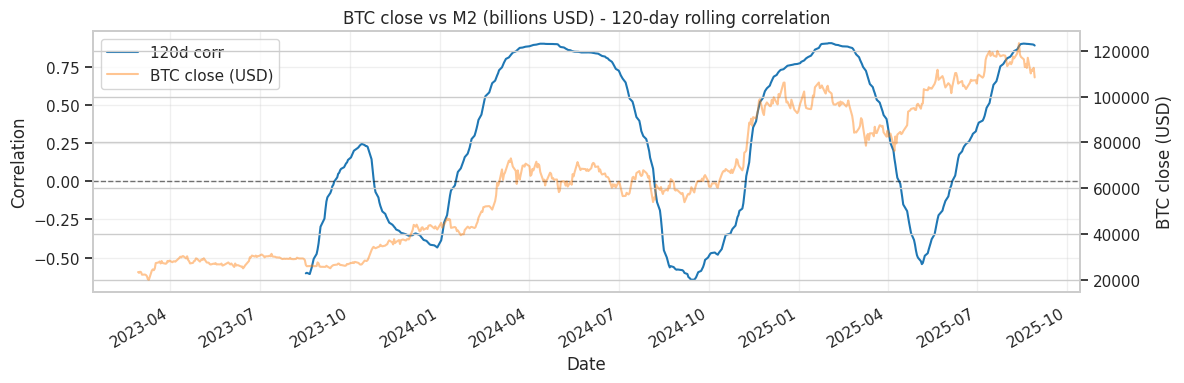

In [3]:
# Plot 120-day rolling correlation with BTC price overlay
fig, ax = plt.subplots(figsize=(12,4))
corr_line = combined['roll_corr_120d'].plot(ax=ax, color='tab:blue', label='120d corr')
ax.axhline(0, color='k', lw=1, linestyle='--', alpha=0.6)
ax.set_title('BTC close vs M2 (billions USD) - 120-day rolling correlation')
ax.set_ylabel('Correlation')
ax.set_xlabel('Date')
ax.grid(True, alpha=0.3)

# Secondary axis: BTC close price
ax2 = ax.twinx()
price_line = combined['close'].plot(ax=ax2, color='tab:orange', alpha=0.45, label='BTC close (USD)')
ax2.set_ylabel('BTC close (USD)')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


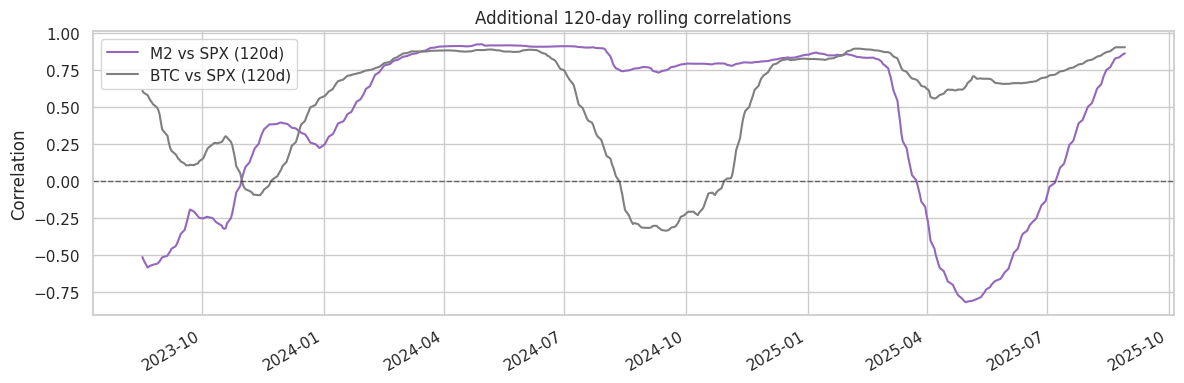

In [4]:
# Plot additional 120d rolling correlations: M2 vs SPX, BTC vs SPX
fig, ax = plt.subplots(figsize=(12,4))
combined['roll_corr_spx_m2_120d'].plot(ax=ax, label='M2 vs SPX (120d)', color='tab:purple')
combined['roll_corr_btc_spx_120d'].plot(ax=ax, label='BTC vs SPX (120d)', color='tab:gray')
ax.axhline(0, color='k', lw=1, linestyle='--', alpha=0.6)
ax.set_title('Additional 120-day rolling correlations')
ax.set_ylabel('Correlation')
ax.legend()
plt.tight_layout()
plt.show()


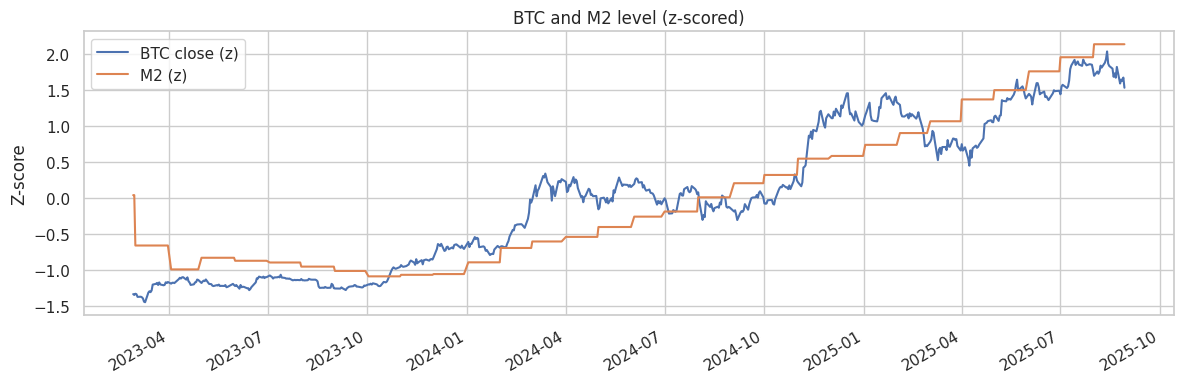

In [5]:
# Context: normalized price and M2 on same axis (z-scores)
from scipy.stats import zscore
plot_df = combined[['close','m2_billion_usd']].dropna().apply(zscore)
fig, ax = plt.subplots(figsize=(12,4))
plot_df.rename(columns={'close':'BTC close (z)', 'm2_billion_usd':'M2 (z)'}).plot(ax=ax)

ax.set_title('BTC and M2 level (z-scored)')
ax.set_ylabel('Z-score')
plt.tight_layout()
plt.show()


In [6]:
# Quick stats to highlight noteworthy relationships
import numpy as np
stats = {}
stats['sample_span'] = f"{combined.index.min().date()} to {combined.index.max().date()}"
stats['full_sample_corr'] = combined['close'].corr(combined['m2_billion_usd'])
stats['latest_corr_120d'] = combined['roll_corr_120d'].iloc[-1]
last_year = combined.index.max() - pd.Timedelta(days=365)
mask_year = combined.index >= last_year
stats['corr_last_year'] = combined.loc[mask_year, 'close'].corr(combined.loc[mask_year, 'm2_billion_usd'])
stats['m2_latest_bil_usd'] = combined['m2_billion_usd'].iloc[-1]
stats['btc_latest_close'] = combined['close'].iloc[-1]
pd.Series(stats)


sample_span          2023-02-27 to 2025-08-29
full_sample_corr                     0.921527
latest_corr_120d                     0.888038
corr_last_year                       0.801049
m2_latest_bil_usd                     22108.4
btc_latest_close                     108377.4
dtype: object

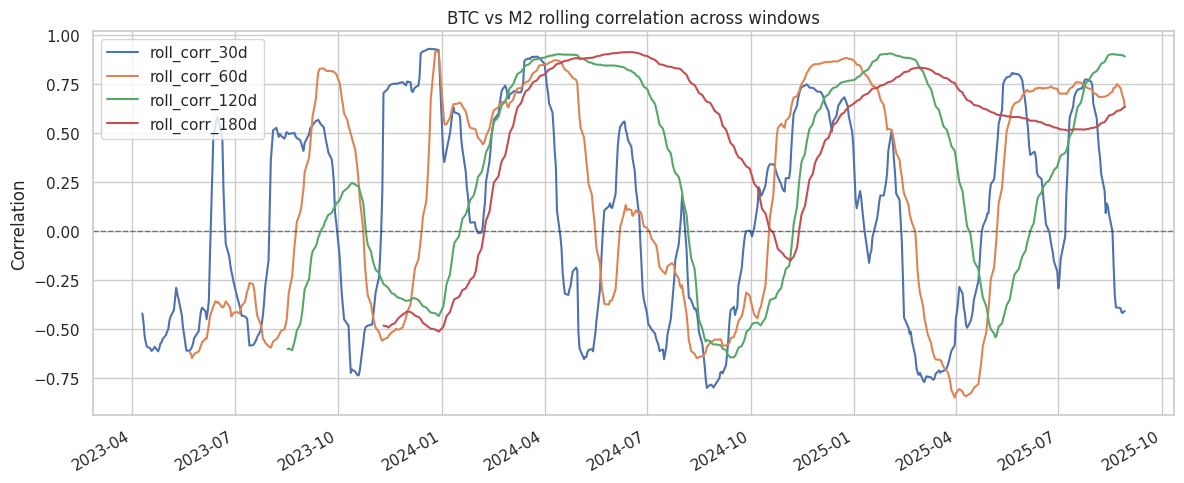

,roll_corr_30d,roll_corr_60d,roll_corr_120d,roll_corr_180d
2025-08-27,-0.419155,0.686760,0.895007,0.623303
2025-08-28,-0.411005,0.669109,0.893507,0.629540
2025-08-29,-0.410024,0.631096,0.888038,0.632034


In [7]:
# Optional: compare multiple rolling windows to see stability
windows = [30, 60, 120, 180]
multi = {}
for w in windows:
    multi[f'roll_corr_{w}d'] = combined['close'].rolling(w).corr(combined['m2_billion_usd'])
multi_df = pd.DataFrame(multi, index=combined.index)

ax = multi_df.plot(figsize=(12,5))
ax.axhline(0, color='k', linestyle='--', lw=1, alpha=0.5)
ax.set_title('BTC vs M2 rolling correlation across windows')
ax.set_ylabel('Correlation')
plt.tight_layout()
plt.show()

multi_df.tail(3)


In [8]:
# Correlation matrix for the three series
corr_full = combined[['close','spx_close','m2_billion_usd']].corr()
corr_last_120 = combined[['close','spx_close','m2_billion_usd']].tail(120).corr()
print('Full-sample correlation:')
display(corr_full)
print('Trailing 120-day correlation:')
display(corr_last_120)

pd.DataFrame({
    'latest_roll_corr_btc_m2': [combined['roll_corr_120d'].iloc[-1]],
    'latest_roll_corr_spx_m2': [combined['roll_corr_spx_m2_120d'].iloc[-1]],
    'latest_roll_corr_btc_spx': [combined['roll_corr_btc_spx_120d'].iloc[-1]],
    'half_life_days_OU_btc_m2': [np.nan],  # placeholder if needed
})


Full-sample correlation:


,close,spx_close,m2_billion_usd
close,1.000000,0.940803,0.921527
spx_close,0.940803,1.000000,0.860499
m2_billion_usd,0.921527,0.860499,1.000000


Trailing 120-day correlation:


,close,spx_close,m2_billion_usd
close,1.000000,0.903257,0.888038
spx_close,0.903257,1.000000,0.861211
m2_billion_usd,0.888038,0.861211,1.000000


,latest_roll_corr_btc_m2,latest_roll_corr_spx_m2,latest_roll_corr_btc_spx,half_life_days_OU_btc_m2
0,0.888038,0.861211,0.903257,NaN


### BTC–M2 spread and OU mean-reversion check
Define a scale-free spread = zscore(BTC close) − zscore(M2), then test whether it follows an OU process (AR(1) form) and estimate its half-life.

AR(1) coef a=0.0013, b=0.9718
Implied OU mean mu=0.0445, half-life=24.3 days
Mean-reverting? True


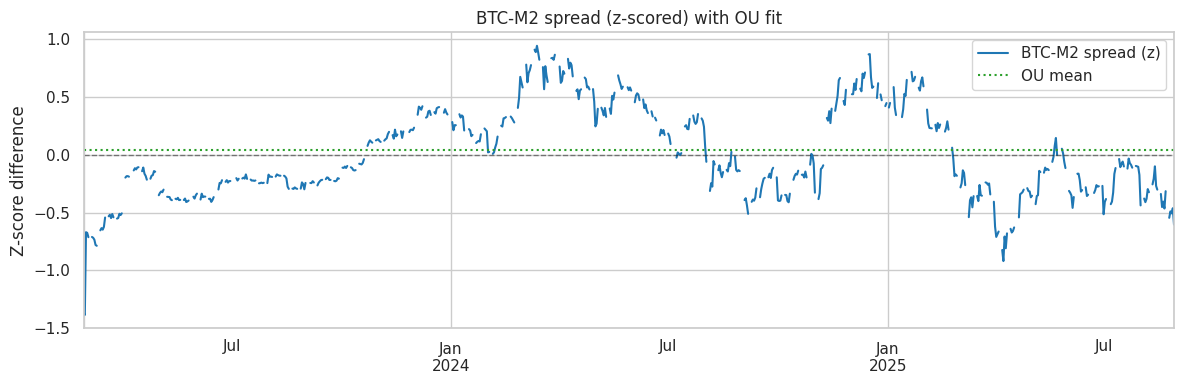

2025-08-25   -0.545651
2025-08-26   -0.489901
2025-08-27   -0.506823
2025-08-28   -0.462767
2025-08-29   -0.604214
Freq: D, Name: spread_z_btc_minus_m2, dtype: float64

In [9]:
from scipy.stats import zscore

spread_df = combined[['close','m2_billion_usd']].dropna()
spread_z = spread_df.apply(zscore)
spread = (spread_z['close'] - spread_z['m2_billion_usd']).rename('spread_z_btc_minus_m2')
spread = spread.asfreq('D')

# Fit AR(1) to spread to approximate OU dynamics
x = spread.dropna().values
x_t, x_tp1 = x[:-1], x[1:]
X = np.vstack([np.ones_like(x_t), x_t]).T
a, b = np.linalg.lstsq(X, x_tp1, rcond=None)[0]
mu = a / (1 - b) if abs(1 - b) > 1e-8 else np.nan
phi = b
k = -np.log(phi) if phi > 0 else np.nan
half_life = np.log(2) / k if (not np.isnan(k) and k > 0) else np.inf
is_mean_reverting = (abs(phi) < 1) and (half_life < np.inf)

print(f'AR(1) coef a={a:.4f}, b={b:.4f}')
print(f'Implied OU mean mu={mu:.4f}, half-life={half_life:.1f} days')
print(f'Mean-reverting? {is_mean_reverting}')

fig, ax = plt.subplots(figsize=(12,4))
spread.plot(ax=ax, color='tab:blue', label='BTC-M2 spread (z)')
ax.axhline(mu, color='tab:green', linestyle=':', lw=1.5, label='OU mean')
ax.axhline(0, color='k', linestyle='--', lw=1, alpha=0.5)
ax.set_title('BTC-M2 spread (z-scored) with OU fit')
ax.set_ylabel('Z-score difference')
ax.legend()
plt.tight_layout()
plt.show()

spread.tail()


### When does the spread revert to zero?
Using the OU parameters, compute the expected time for the z-scored BTC–M2 spread to cross 0 (in expectation).

In [10]:
target = 0.0
spread0 = spread.iloc[-1]
if (phi > 0) and (abs(phi) < 1) and (spread0 != mu) and ((target - mu) / (spread0 - mu) > 0):
    t_days = np.log((target - mu) / (spread0 - mu)) / np.log(phi)
    expected_date = spread.index[-1] + pd.Timedelta(days=t_days)
    print(f'Current spread: {spread0:.4f}')
    print(f'Expected zero-cross (in mean) in {t_days:.1f} days → around {expected_date.date()}')
else:
    print('Zero-mean crossing not well-defined with current OU params (check phi sign or spread=mu).')


Current spread: -0.6042
Expected zero-cross (in mean) in 93.9 days → around 2025-11-30
